<a href="https://colab.research.google.com/github/ymuto0302/PublicLecture2025/blob/main/pref_crime_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 都道府県セグメンテーション

県民所得，人口密度，犯罪率のデータに基づき，都道府県のグループ分けを試みる。

本ノートブックにて用いるデータは，下記の公的データをまとめたものである。
- 県民所得データ：令和４年度県民経済計算（内閣府経済社会総合研究所）
- 人口密度データ：uub.jp（都道府県市区町村統計サイト）から令和５年10月1日現在の推計人口および令和５年7月1日現在の国土地理院データから面積を取得
- 人口あたり犯罪件数：令和5年犯罪統計資料（警察庁），令和6年警察白書 → 人口10万人当たり刑法犯認知件数（令和5年）

In [ ]:
# グラフ表示の際，日本語を表示できるように japanize_matplotlib をインストール
!pip install japanize_matplotlib

In [ ]:
# 必要なライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

## STEP 1: データの読み込みと確認
独自に作成した crime.csv を読み込む。

In [ ]:
# データの読み込み
# Mall Customer Segmentation Datasetを使用
df = pd.read_csv('crime.csv')

print(f"データ件数: {df.shape[0]}")

# データの先頭5行を確認
df.head()

データ件数: 47


,都道府県,県民所得,人口密度,犯罪件数
0,北海道,264,64.93,481
1,青森県,236,122.81,266
2,岩手県,252,76.14,240
3,宮城県,290,310.83,376
4,秋田県,246,78.50,287


In [ ]:
print("\n=== 基本統計量の確認 ===")
df.describe()


=== 基本統計量の確認 ===


,県民所得,人口密度,犯罪件数
count,47.000000,47.000000,47.000000
mean,290.829787,651.078723,491.042553
std,44.135325,1222.409347,127.819159
min,217.000000,64.930000,240.000000
25%,264.500000,168.015000,424.500000
50%,290.000000,259.540000,489.000000
75%,308.500000,460.200000,568.000000
max,521.000000,6409.290000,912.000000


In [ ]:
print("\n=== 欠損値の確認 ===")
df.isnull().sum()


=== 欠損値の確認 ===


,0
都道府県,0
県民所得,0
人口密度,0
犯罪件数,0


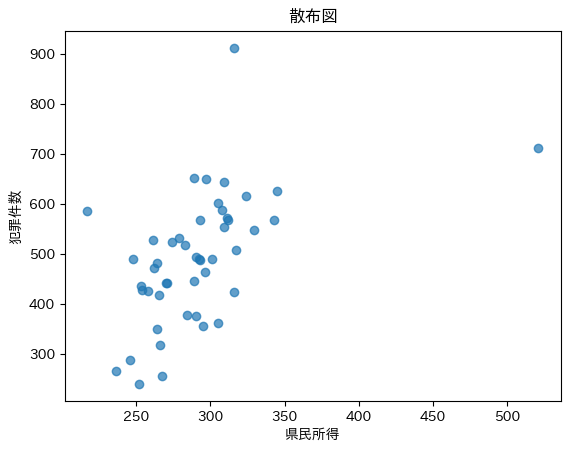

In [ ]:
# データ分布の可視化

# クラスタリング用の特徴量を選択: 県民所得と犯罪件数を使用
features = ['県民所得', '犯罪件数']
X = df[features].copy()

# 散布図プロット
plt.scatter(X['県民所得'], X['犯罪件数'], alpha=0.7)
plt.xlabel('県民所得')
plt.ylabel('犯罪件数')
plt.title('散布図')
plt.show()

## STEP 2: データの前処理（標準化）

In [ ]:
# データの標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\n=== 標準化後のデータ統計 ===")
X_scaled_df = pd.DataFrame(X_scaled)
X_scaled_df.describe()


=== 標準化後のデータ統計 ===


,0,1
count,4.700000e+01,4.700000e+01
mean,-7.558965e-17,-2.055094e-16
std,1.010811e+00,1.010811e+00
min,-1.690890e+00,-1.985278e+00
25%,-6.030191e-01,-5.262275e-01
50%,-1.900424e-02,-1.615279e-02
75%,4.046928e-01,6.085899e-01
max,5.271483e+00,3.328988e+00


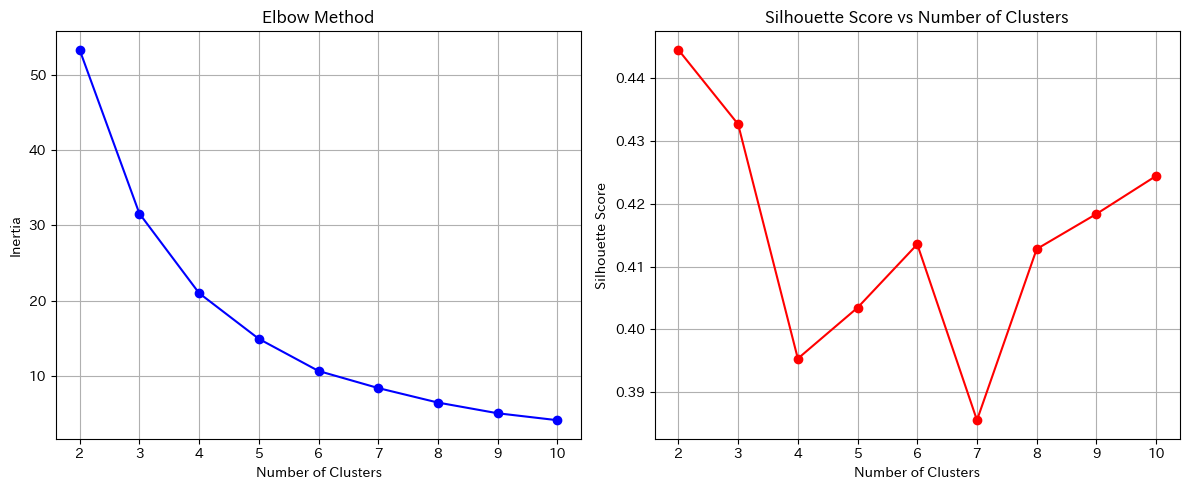

シルエット分析による最適クラスタ数: 2


In [ ]:
from sklearn.metrics import silhouette_score

# 最適なクラスター数の決定

# エルボー法 ＆ シルエット分析
inertias = []
silhouette_scores = []
k_range = range(2, 11) # クラスタ数の候補値を 2〜10 とする

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# 結果の可視化
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'ro-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.grid(True)

plt.tight_layout()
plt.show()

# 最適なクラスター数を出力
best_k_silhouette = k_range[np.argmax(silhouette_scores)]
print(f"シルエット分析による最適クラスタ数: {best_k_silhouette}")

## STEP 3: k-means法によるクラスタリング

In [ ]:
# k=6でクラスタリング実行
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# 結果をデータフレームに追加
df['Cluster'] = cluster_labels

# クラスター別の件数
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
print(f"\n各クラスターの件数:")
for i, count in enumerate(cluster_counts):
    print(f"クラスター {i}: {count}件")


各クラスターの件数:
クラスター 0: 5件
クラスター 1: 20件
クラスター 2: 4件
クラスター 3: 1件
クラスター 4: 6件
クラスター 5: 11件


## STEP 4: 結果の評価と解釈

In [ ]:
# クラスター別の統計情報
print("\n=== クラスター別統計情報 ===")
cluster_summary = df.groupby('Cluster')[['県民所得', '人口密度', '犯罪件数']].agg({
    '県民所得': ['mean', 'std'],
    '人口密度': ['mean', 'std'],
    '犯罪件数': ['mean', 'std']
}).round(2)

print(cluster_summary)


=== クラスター別統計情報 ===
           県民所得            人口密度             犯罪件数        
           mean    std     mean      std    mean     std
Cluster                                                 
0        298.00  12.67   208.45    66.09  379.20   26.71
1        271.00  20.32   231.05   122.63  479.20   43.54
2        302.75  12.07  1597.85  2028.82  714.50  131.71
3        521.00    NaN  6409.29      NaN  712.00     NaN
4        255.17  12.62   102.07    22.04  286.17   41.32
5        317.82  16.04  1047.67  1062.73  573.82   33.11


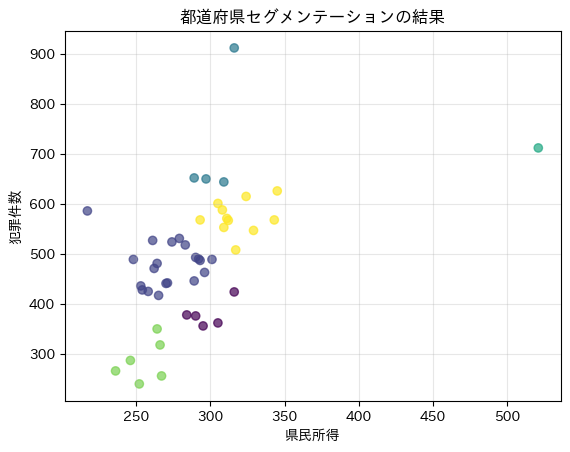

In [ ]:
# クラスタリング結果の散布図
plt.scatter(X[features[0]],  # X
            X[features[1]], # Y
            c=df['Cluster'], # 色はクラスタ番号に従う
            alpha=0.7) # バブルの透明度

plt.xlabel('県民所得')
plt.ylabel('犯罪件数')
plt.title('都道府県セグメンテーションの結果')
plt.grid(True, alpha=0.3)

In [ ]:
# 各クラスタに含まれる都道府県名を観察する
for i in range(optimal_k):
    prefs = df[df['Cluster']==i]['都道府県'].tolist()
    print(f"クラスタ {i}: {prefs}")

クラスタ 0: ['宮城県', '新潟県', '富山県', '福井県', '長野県']
クラスタ 1: ['北海道', '栃木県', '石川県', '山梨県', '岐阜県', '奈良県', '和歌山県', '鳥取県', '岡山県', '山口県', '徳島県', '愛媛県', '高知県', '佐賀県', '長崎県', '熊本県', '大分県', '宮崎県', '鹿児島県', '沖縄県']
クラスタ 2: ['茨城県', '群馬県', '大阪府', '福岡県']
クラスタ 3: ['東京都']
クラスタ 4: ['青森県', '岩手県', '秋田県', '山形県', '福島県', '島根県']
クラスタ 5: ['埼玉県', '千葉県', '神奈川県', '静岡県', '愛知県', '三重県', '滋賀県', '京都府', '兵庫県', '広島県', '香川県']


---
## 人口密度 vs 犯罪件数

## STEP 1: データの確認

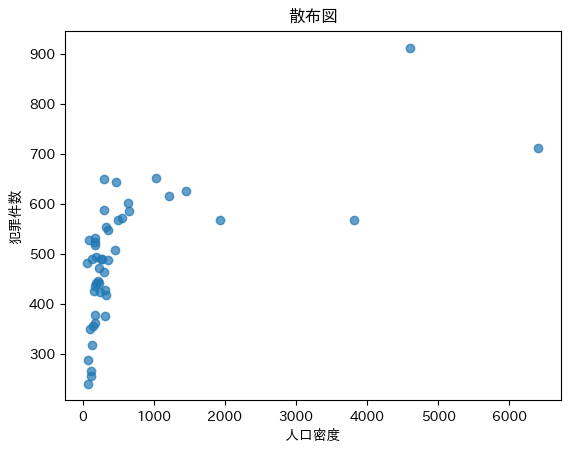

In [ ]:
# データ分布の可視化

# クラスタリング用の特徴量を選択: 人口密度と犯罪件数を使用
features = ['人口密度', '犯罪件数']
X = df[features].copy()

# scatter plot
plt.scatter(X['人口密度'], X['犯罪件数'], alpha=0.7)
plt.xlabel('人口密度')
plt.ylabel('犯罪件数')
plt.title('散布図')
plt.show()


## STEP 2: データの前処理（対数変換 & 標準化）

東京都と大阪府の人口密度が飛び抜けてしまうため，横軸を対数スケールに変換して表示する

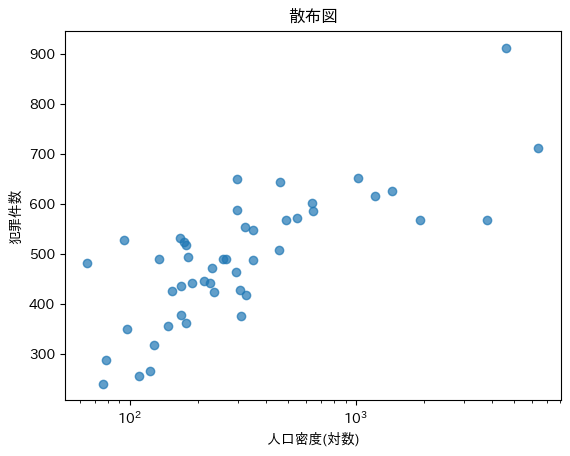

In [ ]:
# データ分布の可視化： 人口密度を対数スケールへ変換
plt.scatter(X['人口密度'], X['犯罪件数'], alpha=0.7)
plt.xlabel('人口密度(対数)')
plt.ylabel('犯罪件数')
plt.title('散布図')
plt.xscale('log') # 横軸を対数スケールにて表示
plt.show()


In [ ]:
# 人口密度を対数スケールに変換した後，標準化を行う
df['log_人口密度'] = np.log(df['人口密度'])
features = ['log_人口密度', '犯罪件数']
X = df[features].copy()

# データの標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\n=== 標準化後のデータ統計 ===")
X_scaled_df = pd.DataFrame(X_scaled)
X_scaled_df.describe()


=== 標準化後のデータ統計 ===


,0,1
count,4.700000e+01,4.700000e+01
mean,-1.889741e-17,-2.055094e-16
std,1.010811e+00,1.010811e+00
min,-1.504322e+00,-1.985278e+00
25%,-5.855427e-01,-5.262275e-01
50%,-1.652997e-01,-1.615279e-02
75%,3.881726e-01,6.085899e-01
max,2.933500e+00,3.328988e+00


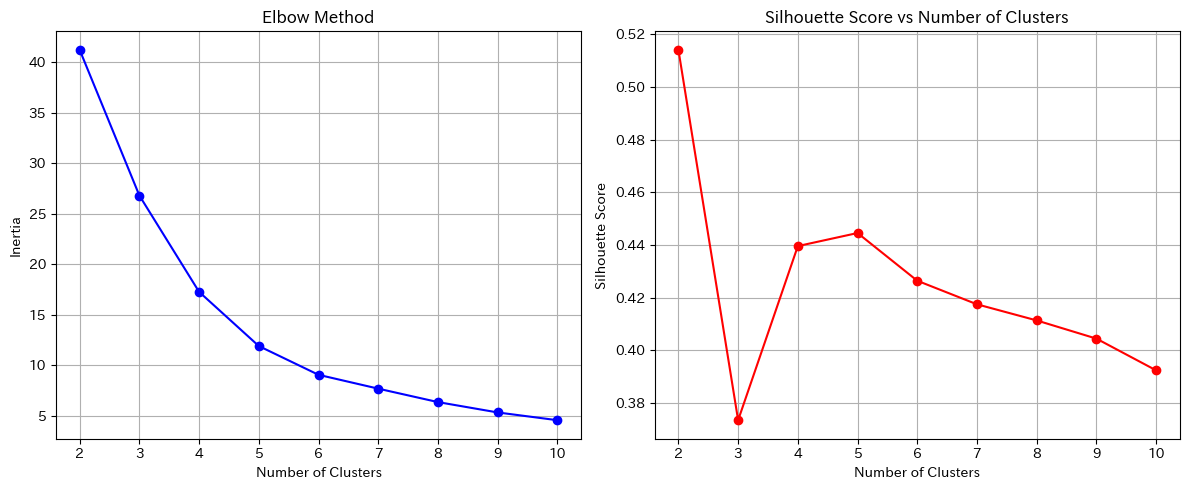

シルエット分析による最適クラスタ数: 2


In [ ]:
from sklearn.metrics import silhouette_score

# 最適なクラスター数の決定

# エルボー法 ＆ シルエット分析
inertias = []
silhouette_scores = []
k_range = range(2, 11) # クラスタ数の候補値を 2〜10 とする

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# 結果の可視化
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'ro-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.grid(True)

plt.tight_layout()
plt.show()

# 最適なクラスター数を出力
best_k_silhouette = k_range[np.argmax(silhouette_scores)]
print(f"シルエット分析による最適クラスタ数: {best_k_silhouette}")

## STEP 3: k-means法によるクラスタリング

In [ ]:
# k=5でクラスタリング実行
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# 結果をデータフレームに追加
df['Cluster'] = cluster_labels

# クラスター別の件数
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
print(f"\n各クラスターの件数:")
for i, count in enumerate(cluster_counts):
    print(f"クラスター {i}: {count}件")


各クラスターの件数:
クラスター 0: 9件
クラスター 1: 7件
クラスター 2: 7件
クラスター 3: 10件
クラスター 4: 14件


## STEP 4: 結果の評価と解釈

In [ ]:
# クラスター別の統計情報
print("\n=== クラスター別統計情報 ===")
cluster_summary = df.groupby('Cluster')[['県民所得', '人口密度', '犯罪件数']].agg({
    '県民所得': ['mean', 'std'],
    '人口密度': ['mean', 'std'],
    '犯罪件数': ['mean', 'std']
}).round(2)

print(cluster_summary)


=== クラスター別統計情報 ===
           県民所得            人口密度             犯罪件数        
           mean    std     mean      std    mean     std
Cluster                                                 
0        268.33  22.74   122.99    36.70  312.56   51.64
1        271.29  14.47   141.95    46.20  509.00   20.63
2        350.00  77.79  2921.62  2060.47  664.57  120.01
3        299.50  30.63   451.72   132.08  581.60   43.13
4        279.29  19.80   252.26    60.38  445.36   32.23


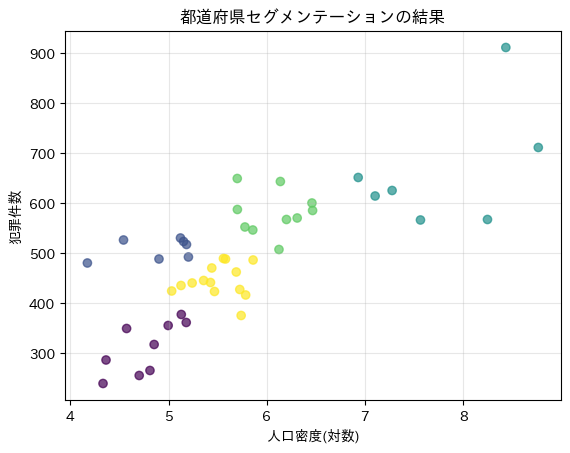

In [ ]:
# クラスタリング結果の散布図
plt.scatter(X[features[0]],  # X
            X[features[1]], # Y
            c=df['Cluster'], # 色はクラスタ番号に従う
            alpha=0.7) # バブルの透明度

plt.xlabel('人口密度(対数)')
plt.ylabel('犯罪件数')
plt.title('都道府県セグメンテーションの結果')
plt.grid(True, alpha=0.3)

In [ ]:
# 各クラスタに含まれる都道府県名を観察する
for i in range(optimal_k):
    prefs = df[df['Cluster']==i]['都道府県'].tolist()
    print(f"クラスタ {i}: {prefs}")

クラスタ 0: ['青森県', '岩手県', '秋田県', '山形県', '福島県', '新潟県', '福井県', '長野県', '島根県']
クラスタ 1: ['北海道', '山梨県', '岐阜県', '徳島県', '高知県', '大分県', '宮崎県']
クラスタ 2: ['埼玉県', '千葉県', '東京都', '神奈川県', '愛知県', '大阪府', '福岡県']
クラスタ 3: ['茨城県', '群馬県', '静岡県', '三重県', '滋賀県', '京都府', '兵庫県', '広島県', '香川県', '沖縄県']
クラスタ 4: ['宮城県', '栃木県', '富山県', '石川県', '奈良県', '和歌山県', '鳥取県', '岡山県', '山口県', '愛媛県', '佐賀県', '長崎県', '熊本県', '鹿児島県']
